In [308]:
from __future__ import unicode_literals, print_function, division
from io import open
import unicodedata
import string
import re
import random
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np

from torch.autograd import Variable

plt.switch_backend('agg')
import matplotlib.ticker as ticker
import numpy as np
%matplotlib inline
from torch.utils.data import Dataset

import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
from torch.nn import functional

import time
import math

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
USE_CUDA = torch.cuda.is_available()

MAX_LENGTH = 5 #temp

MAX_VOCAB_SIZE = 1000

PAD_IDX = 0 
SOS_token = 1
EOS_token = 2
UNK_IDX = 3


In [309]:
import torch
from torch.nn import functional
from torch.autograd import Variable

def sequence_mask(sequence_length, max_len=None):
    if max_len is None:
        max_len = sequence_length.data.max()
    batch_size = sequence_length.size(0)
    seq_range = torch.range(0, max_len - 1).long()
    seq_range_expand = seq_range.unsqueeze(0).expand(batch_size, max_len)
    seq_range_expand = Variable(seq_range_expand)
    if sequence_length.is_cuda:
        seq_range_expand = seq_range_expand.cuda()
    seq_length_expand = (sequence_length.unsqueeze(1)
                         .expand_as(seq_range_expand))
    return seq_range_expand < seq_length_expand


def masked_cross_entropy(logits, target, length):
    length = Variable(torch.LongTensor(length))

    """
    Args:
        logits: A Variable containing a FloatTensor of size
            (batch, max_len, num_classes) which contains the
            unnormalized probability for each class.
        target: A Variable containing a LongTensor of size
            (batch, max_len) which contains the index of the true
            class for each corresponding step.
        length: A Variable containing a LongTensor of size (batch,)
            which contains the length of each data in a batch.
    Returns:
        loss: An average loss value masked by the length.
    """

    # logits_flat: (batch * max_len, num_classes)
    logits_flat = logits.view(-1, logits.size(-1))
    # log_probs_flat: (batch * max_len, num_classes)
    log_probs_flat = functional.log_softmax(logits_flat)
    # target_flat: (batch * max_len, 1)
    target_flat = target.view(-1, 1)
    # losses_flat: (batch * max_len, 1)
    losses_flat = -torch.gather(log_probs_flat, dim=1, index=target_flat)
    # losses: (batch, max_len)
    losses = losses_flat.view(*target.size())
    # mask: (batch, max_len)
    mask = sequence_mask(sequence_length=length, max_len=target.size(1))
    losses = losses * mask.float()
    loss = losses.sum() / length.float().sum()
    return loss


# Remove punctuation
def removePunctuation(s):

    to_remove = ('&lt;', '&gt;', '&amp;', '&apos;', '&quot;')
    table = str.maketrans(dict.fromkeys('.!?:,'))
    s = s.translate(table)
    for i in to_remove:
        s=s.replace(i,'')   
    s = s.strip()
    
    return s


from typing import List
from collections import Counter, namedtuple
from itertools import zip_longest

def tokenize_13a(line):
    """
    Tokenizes an input line using a relatively minimal tokenization that is however equivalent to mteval-v13a, used by WMT.
    :param line: a segment to tokenize
    :return: the tokenized line
    """

    norm = line

    # language-independent part:
    norm = norm.replace('<skipped>', '')
    norm = norm.replace('-\n', '')
    norm = norm.replace('\n', ' ')
    norm = norm.replace('&quot;', '"')
    norm = norm.replace('&amp;', '&')
    norm = norm.replace('&lt;', '<')
    norm = norm.replace('&gt;', '>')

    # language-dependent part (assuming Western languages):
    norm = " {} ".format(norm)
    norm = re.sub(r'([\{-\~\[-\` -\&\(-\+\:-\@\/])', ' \\1 ', norm)
    norm = re.sub(r'([^0-9])([\.,])', '\\1 \\2 ', norm)  # tokenize period and comma unless preceded by a digit
    norm = re.sub(r'([\.,])([^0-9])', ' \\1 \\2', norm)  # tokenize period and comma unless followed by a digit
    norm = re.sub(r'([0-9])(-)', '\\1 \\2 ', norm)  # tokenize dash when preceded by a digit
    norm = re.sub(r'\s+', ' ', norm)  # one space only between words
    norm = re.sub(r'^\s+', '', norm)  # no leading space
    norm = re.sub(r'\s+$', '', norm)  # no trailing space

    return norm

def corpus_bleu(sys_stream, ref_streams, smooth='exp', smooth_floor=0.0, force=False, lowercase=False,
                 use_effective_order=False):
    """Produces BLEU scores along with its sufficient statistics from a source against one or more references.
    :param sys_stream: The system stream (a sequence of segments)
    :param ref_streams: A list of one or more reference streams (each a sequence of segments)
    :param smooth: The smoothing method to use
    :param smooth_floor: For 'floor' smoothing, the floor to use
    :param force: Ignore data that looks already tokenized
    :param lowercase: Lowercase the data
    :param tokenize: The tokenizer to use
    :return: a BLEU object containing everything you'd want
    """

    # Add some robustness to the input arguments
    if isinstance(sys_stream, str):
        sys_stream = [sys_stream]
    if isinstance(ref_streams, str):
        ref_streams = [[ref_streams]]

    sys_len = 0
    ref_len = 0

    correct = [0 for n in range(NGRAM_ORDER)]
    total = [0 for n in range(NGRAM_ORDER)]
    

    # look for already-tokenized sentences
    tokenized_count = 0

    fhs = [sys_stream] + ref_streams
    for lines in zip_longest(*fhs):
        if None in lines:
            raise EOFError("Source and reference streams have different lengths!")

        if lowercase:
            lines = [x.lower() for x in lines]
            
        tokenize= 'tokenize_13a'    

        if not (force or tokenize == 'none') and lines[0].rstrip().endswith(' .'):
            tokenized_count += 1

            if tokenized_count == 100:
                logging.warning('That\'s 100 lines that end in a tokenized period (\'.\')')
                logging.warning('It looks like you forgot to detokenize your test data, which may hurt your score.')
                logging.warning('If you insist your data is detokenized, or don\'t care, you can suppress this message with \'--force\'.')

        output, *refs = [tokenize_13a(x.rstrip()) for x in lines]
        

        ref_ngrams, closest_diff, closest_len = ref_stats(output, refs)
        

        sys_len += len(output.split())
        ref_len += closest_len

        sys_ngrams = extract_ngrams(output)
        for ngram in sys_ngrams.keys():
            n = len(ngram.split())
            correct[n-1] += min(sys_ngrams[ngram], ref_ngrams.get(ngram, 0))
            total[n-1] += sys_ngrams[ngram]
            

    return compute_bleu(correct, total, sys_len, ref_len, smooth, smooth_floor, use_effective_order)
  
  
# n-gram order. Don't change this.
NGRAM_ORDER = 4
  
def compute_bleu(correct: List[int], total: List[int], sys_len: int, ref_len: int, smooth = 'none', smooth_floor = 0.01,
                 use_effective_order = False):
    """Computes BLEU score from its sufficient statistics. Adds smoothing.
    :param correct: List of counts of correct ngrams, 1 <= n <= NGRAM_ORDER
    :param total: List of counts of total ngrams, 1 <= n <= NGRAM_ORDER
    :param sys_len: The cumulative system length
    :param ref_len: The cumulative reference length
    :param smooth: The smoothing method to use
    :param smooth_floor: The smoothing value added, if smooth method 'floor' is used
    :param use_effective_order: Use effective order.
    :return: A BLEU object with the score (100-based) and other statistics.
    """

    precisions = [0 for x in range(NGRAM_ORDER)]

    smooth_mteval = 1.
    effective_order = NGRAM_ORDER
    for n in range(NGRAM_ORDER):
        if total[n] == 0:
            break

        if use_effective_order:
            effective_order = n + 1

        if correct[n] == 0:
            if smooth == 'exp':
                smooth_mteval *= 2
                precisions[n] = 100. / (smooth_mteval * total[n])
            elif smooth == 'floor':
                precisions[n] = 100. * smooth_floor / total[n]
        else:
            precisions[n] = 100. * correct[n] / total[n]

    # If the system guesses no i-grams, 1 <= i <= NGRAM_ORDER, the BLEU score is 0 (technically undefined).
    # This is a problem for sentence-level BLEU or a corpus of short sentences, where systems will get no credit
    # if sentence lengths fall under the NGRAM_ORDER threshold. This fix scales NGRAM_ORDER to the observed
    # maximum order. It is only available through the API and off by default

    brevity_penalty = 1.0
    if sys_len < ref_len:
        brevity_penalty = math.exp(1 - ref_len / sys_len) if sys_len > 0 else 0.0
        

    bleu = brevity_penalty * math.exp(sum(map(my_log, precisions[:effective_order])) / effective_order)

    return bleu 
  
  
def ref_stats(output, refs):
    ngrams = Counter()
    closest_diff = None
    closest_len = None
    for ref in refs:
        tokens = ref.split()
        reflen = len(tokens)
        diff = abs(len(output.split()) - reflen)
        if closest_diff is None or diff < closest_diff:
            closest_diff = diff
            closest_len = reflen
        elif diff == closest_diff:
            if reflen < closest_len:
                closest_len = reflen

        ngrams_ref = extract_ngrams(ref)
        for ngram in ngrams_ref.keys():
            ngrams[ngram] = max(ngrams[ngram], ngrams_ref[ngram])

    return ngrams, closest_diff, closest_len
  
  
def extract_ngrams(line, min_order=1, max_order=NGRAM_ORDER) -> Counter:
    """Extracts all the ngrams (1 <= n <= NGRAM_ORDER) from a sequence of tokens.
    :param line: a segment containing a sequence of words
    :param max_order: collect n-grams from 1<=n<=max
    :return: a dictionary containing ngrams and counts
    """

    ngrams = Counter()
    tokens = line.split()
    for n in range(min_order, max_order + 1):
        for i in range(0, len(tokens) - n + 1):
            ngram = ' '.join(tokens[i: i + n])
            ngrams[ngram] += 1

    return ngrams  

def my_log(num):
    """
    Floors the log function
    :param num: the number
    :return: log(num) floored to a very low number
    """

    if num == 0.0:
        return -9999999999
    return math.log(num)
  

class Lang:
    def __init__(self, name):
        self.name = name
        self.word2index = {}
        self.word2index = {"PAD" : 0, "<SOS>" : 1, "EOS" : 2, "UNK" : 3}
        self.word2count = {}
        self.index2word = {0: "PAD", 1: "<SOS>", 2: "EOS", 3: "UNK"}
        self.n_words = 4  # Count SOS and EOS and Pad
        self.all_words = []

    def addSentence(self, sentence):
        'Add all words from all sentences'
        for word in sentence.split(' '):
            if word.strip(): #if not empty space
                self.all_words.append(word)
                
                
    def build_vocab(self, vocab_size=MAX_VOCAB_SIZE):
        'Build vocabulary of vocab_size most common words'
        
        token_counter = Counter(self.all_words)
        vocab, count = zip(*token_counter.most_common(vocab_size)) #* unzips the tuples
        for word in vocab:
            self.addWord(word)

    def addWord(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.n_words
            self.word2count[word] = 1
            self.index2word[self.n_words] = word
            self.n_words += 1
        else:
            self.word2count[word] += 1
            
def remove_blanks(pair):
    '''Remove empty lines'''
    if len(pair[0]) == 0 and len(pair[1]) == 0:
        return False
    else:
        return True
    
def set_max_length(pair, max_length=MAX_LENGTH):
    if len(pair[0].split(' ')) > max_length or len(pair[1].split(' '))>max_length:
        return False
    else:
        return True
    
def readLangs(filename1, filename2, reverse=False):
    print("Reading lines...")

    # Read the file and split into lines
    with open(filename1, encoding='utf-8') as f:
        lines1 = f.read().strip().split('\n')
        
    with open(filename2, encoding='utf-8') as f:
        lines2 = f.read().strip().split('\n')   
        
    # Remove punctuation
    lines1 = [removePunctuation(l) for l in lines1]
    lines2 = [removePunctuation(l) for l in lines2]
              
    # Reverse pairs, make Lang instances
    if reverse: #change from english->french to french->english for example
        pairs =list(zip(lines2, lines1))
        input_lang = Lang(filename2[-2:]) #take last two letters
        output_lang = Lang(filename1[-2:])
    else:
        pairs =list(zip(lines1, lines2))
        input_lang = Lang(filename1[-2:])
        output_lang = Lang(filename2[-2:])
            
        

    pairs = list(filter(remove_blanks, pairs))  
    pairs = list(filter(set_max_length, pairs))

    return input_lang, output_lang, pairs 


def prepareData(lang1, lang2, num_sent=None, reverse=False):
    
    input_lang, output_lang, pairs = readLangs(lang1, lang2, reverse)
    
    pairs = pairs[:num_sent]
    print("Read %s sentence pairs" % len(pairs))
    
    print("Counting words...")
    for pair in pairs:
        input_lang.addSentence(pair[0])
        output_lang.addSentence(pair[1])
        
    input_lang.build_vocab()
    output_lang.build_vocab()
        
    print("Counted words:")
    print(input_lang.name, input_lang.n_words)
    print(output_lang.name, output_lang.n_words)
    
    return input_lang, output_lang, pairs


class VocabDataset(Dataset):
    """
    Class that represents a train/validation/test dataset that's readable for PyTorch
    Note that this class inherits torch.utils.data.Dataset
    """

    def __init__(self, data_tuple, word2id_lang1, word2id_lang2):
        """
        @param data_list: list of character
        @param target_list: list of targets

        """
        self.data_list1, self.data_list2 = zip(*data_tuple)
        assert (len(self.data_list1) == len(self.data_list2))
        self.word2id1 = word2id_lang1
        self.word2id2 = word2id_lang2

    def __len__(self):
        return len(self.data_list1)

    def __getitem__(self, key):
        """
        Triggered when you call dataset[i]
        """
        
        
        input_sentence = [self.word2id1[c] if c in self.word2id1.keys() 
                         else UNK_IDX for c in self.data_list1[key].split()][:MAX_LENGTH-1]
        input_sentence.append(EOS_token)
                                                                   
        output_sentence = [self.word2id2[c] if c in self.word2id2.keys() 
                          else UNK_IDX for c in self.data_list2[key].split()][:MAX_LENGTH-1]
        output_sentence.append(EOS_token)

        return [input_sentence, output_sentence, len(input_sentence), len(output_sentence)]

def vocab_collate_func(batch):
    """
    Customized function for DataLoader that dynamically pads the batch so that all
    data have the same length
    """
    data_list1 = []
    data_list2 = []
    length_list1 = []
    length_list2 = []
     
    # padding
    for datum in batch:
        x1 = datum[0]
        x2 = datum[1]
        len1 = datum[2]
        len2 = datum[3]
        
        length_list1.append(len1)
        length_list2.append(len2)
        #Pad first sentences
        padded_vec1 = np.pad(np.array(x1),
                                pad_width=((0,MAX_LENGTH-len1)),
                                mode="constant", constant_values=0)
        data_list1.append(padded_vec1)
        
        #Pad second sentences
        padded_vec2 = np.pad(np.array(x2),
                        pad_width=((0,MAX_LENGTH-len2)),
                        mode="constant", constant_values=0)
        data_list2.append(padded_vec2)
        
    data_list1 = np.array(data_list1)
    data_list2 = np.array(data_list2)
    length_list1 = np.array(length_list1)
    lenth_list2 = np.array(length_list2)
    
    return [torch.from_numpy(np.array(data_list1)), 
            torch.from_numpy(np.array(data_list2)),
            torch.LongTensor(length_list1), 
            torch.LongTensor(length_list2)]


class EncoderRNN(nn.Module):
    def __init__(self, hidden_size, vocab_size, dropout=0):
        '''Bidirectional RNN'''
        super(EncoderRNN, self).__init__()
        
        self.hidden_size = hidden_size
        self.dropout = dropout
        
        # Embedding input: max_length x batch_size
        # Embedding output: max_length x batch_size x hidden size
        self.embedding = nn.Embedding(vocab_size, hidden_size, padding_idx=0) #vocab size x hidden size
        
        # Input: (max_length x batch_size x hidden_size)
        # Output: hidden - 2 x batch_size x hidden_size
        # Output: outputs max_length x batch_size x hidden_size*2
        self.gru = nn.GRU(hidden_size, hidden_size, dropout=self.dropout, bidirectional=False)
        
    def forward(self, input_seqs, input_lengths, hidden=None):
        # Note: we run this all at once (over multiple batches of multiple sequences)
        embedded = self.embedding(input_seqs)
        outputs, hidden = self.gru(embedded, hidden)
        #outputs = outputs[:, :, :self.hidden_size] + outputs[:, : ,self.hidden_size:] # Sum bidirectional outputs
        return outputs, hidden
    
    
class DecoderRNN(nn.Module):
    def __init__(self, hidden_size, vocab_size):
        super(DecoderRNN, self).__init__()
        
        self.hidden_size = hidden_size
        self.embedding = nn.Embedding(vocab_size, hidden_size, padding_idx=0)
        
        self.gru = nn.GRU(hidden_size, hidden_size)
        self.out = nn.Linear(hidden_size, vocab_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, inp, hidden):
        embedded = self.embedding(inp).unsqueeze(0) #so that we have 1 x batch x hidden
        #print('embedded', embedded.size())
        output = F.relu(embedded)
        #print('after relu', output.size())
        #print('hidden size', hidden.size())
        output, hidden = self.gru(output, hidden)
        output = self.softmax(self.out(output[0]))
        return output, hidden
    
    
def train(inputs, input_lengths, targets, target_lengths, 
          encoder, decoder, encoder_optimizer, decoder_optimizer, criterion, max_length=MAX_LENGTH,
         teacher_forcing_ratio=0.5):
    
    # Zero gradients of both optimizers
    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()
    loss = 0 #
    batch_size = inputs.size()[1]
    #print('input size', inputs.size())
    #print('batch size', batch_size)
    max_targ_len = max_length

    # Run words through encoder
    _, encoder_hidden = encoder(inputs, input_lengths, None)

    
    # Prepare input and output variables
    decoder_input = torch.LongTensor([SOS_token] * batch_size).to(device)
    decoder_hidden = encoder_hidden#[:1] # Use last (forward) hidden state from encoder
    
    #print('time 1 size', decoder_input.size())
    #print('time 1 hidden size', decoder_hidden.size())
    
    #randomly use teacher forcing or not
    use_teacher_forcing = True if random.random() < teacher_forcing_ratio else False

    # Run through decoder one time step at a time using TEACHER FORCING=1.0
    all_decoder_outputs = Variable(torch.zeros(max_targ_len, batch_size, output_lang.n_words))

    if use_teacher_forcing:
        for t in range(max_targ_len):
            decoder_output, decoder_hidden = decoder(
                decoder_input, decoder_hidden)
            
            all_decoder_outputs[t] = decoder_output
            decoder_input = targets[t]
            
    else:
        # Without teacher forcing: use its own predictions as the next input
        for di in range(max_targ_len):
            decoder_output, decoder_hidden = decoder(
                decoder_input, decoder_hidden)
            topv, topi = decoder_output.topk(1)

            decoder_input = topi.squeeze().detach()  # detach from history as input
            
            all_decoder_outputs[di] = decoder_output

                
    loss = masked_cross_entropy(
    all_decoder_outputs.transpose(0, 1).contiguous(),
    targets.transpose(0, 1).contiguous(),
    target_lengths)
        
    loss.backward()

    # Update parameters with optimizers
    encoder_optimizer.step()
    decoder_optimizer.step()
    
    return loss.item()

def trainIters(loader, encoder, decoder, n_iters, print_every=1000, plot_every=100, learning_rate=0.01,
              teacher_forcing_ratio=0.5):
    
    start = time.time()
    encoder_optimizer = optim.SGD(encoder.parameters(), lr=learning_rate)
    decoder_optimizer = optim.SGD(decoder.parameters(), lr=learning_rate)
    criterion = nn.CrossEntropyLoss()

    print_loss_total = 0
    plot_loss_total = 0
    plot_losses = []

    counter = 0
    epoch = 0

    while epoch < n_iters:
        epoch += 1

        # Get training data for this cycle
        for i, (source, target, lengths1, lengths2) in enumerate(loader):

            counter += 1

            # Run the train function
            loss = train(
                source.long().transpose(0,1), lengths1, target.long().transpose(0,1), lengths2,
                encoder, decoder,
                encoder_optimizer, decoder_optimizer, criterion, teacher_forcing_ratio=teacher_forcing_ratio
            )

            # Keep track of loss
            print_loss_total += loss
            plot_loss_total += loss


            if counter % print_every == 0:
                print_loss_avg = print_loss_total / print_every
                print_loss_total = 0
                print_summary = '%s (%d %d%%) %.4f' % (time_since(start, epoch / n_iters), epoch, 
                                                       epoch / n_iters * 100, print_loss_avg)
                print(print_summary)


            if counter % plot_every == 0:
                plot_loss_avg = plot_loss_total / plot_every
                plot_losses.append(plot_loss_avg)
                plot_loss_total = 0

    showPlot(plot_losses)
    return plot_losses

def evaluate(encoder, decoder, sentence, input_lengths, translated, search='greedy', max_length=MAX_LENGTH):
    """
    Function that generate translation.
    First, feed the source sentence into the encoder and obtain the hidden states from encoder.
    Secondly, feed the hidden states into the decoder and unfold the outputs from the decoder.
    Lastly, for each outputs from the decoder, collect the corresponding words in the target language's vocabulary.
    And collect the attention for each output words.
    @param encoder: the encoder network
    @param decoder: the decoder network
    @param sentence: string, a sentence in source language to be translated
    @param max_length: the max # of words that the decoder can return
    @output decoded_words: a list of words in target language
    @output decoder_attentions: a list of vector, each of which sums up to 1.0
    """    
    # process input sentence
    with torch.no_grad():
        input_tensor = sentence.transpose(0,1)
        input_length = sentence.size()[0]
        
        # encode the source lanugage
        encoder_output, encoder_hidden = encoder(input_tensor, input_lengths, None)

        decoder_input = torch.tensor([SOS_token], device=device)  # SOS
        decoder_hidden = encoder_hidden[:1] # Use last (forward) hidden state from encoder 
        # output of this function
        decoded_words = ''

        for di in range(max_length):
            # for each time step, the decoder network takes two inputs: previous outputs and the previous hidden states
            decoder_output, decoder_hidden = decoder(
                decoder_input, decoder_hidden)
            
            # hint: print out decoder_output and decoder_attention
            # TODO: add your code here to populate decoded_words and decoder_attentions
            # TODO: do this in 2 ways discussed in class: greedy & beam_search
            
            # GREEDY
            topv, topi = decoder_output.data.topk(1) 

            if topi.item() == EOS_token:
                #decoded_words.append('<EOS>')
                break

            else:
                if topi.item() not in [SOS_token, EOS_token, UNK_IDX, PAD_IDX]:
                    decoded_words = decoded_words + ' ' + output_lang.index2word[topi.item()]
            
            decoder_input = topi[0].detach()
        
        translation = ''
        for i in translated: #expected translation
            if i.item() not in [SOS_token, EOS_token, UNK_IDX, PAD_IDX]:
                translation = translation + ' ' + output_lang_v.index2word[i.item()]

        return decoded_words, translation
    
    
def evaluate_batch(loader, encoder, decoder):
    
    decoded_sentences = []
    actual_sentences = []
    
    for i, (source, target, lengths1, lengths2) in enumerate(loader):
        #iterate over batch
        
        for n in range(len(source)):
            # Go sentence by sentence
            
            decoded, actual = evaluate(encoder, decoder, source[n].unsqueeze(0), lengths1[n], target[n])
            decoded_sentences.append(decoded)
            actual_sentences.append(actual)
            
    return decoded_sentences, actual_sentences


def evaluate_bleu(translation_list, reference_list):
    
    return corpus_bleu(translation_list, [reference_list])

#Plot results
def showPlot(points):
    plt.figure()
    fig, ax = plt.subplots()
    # this locator puts ticks at regular intervals
    loc = ticker.MultipleLocator(base=0.2)
    ax.yaxis.set_major_locator(loc)
    plt.plot(points)
    

def as_minutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

def time_since(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (- %s)' % (as_minutes(s), as_minutes(rs))    




In [310]:
en_loc = 'iwslt-vi-en'

In [311]:
input_lang, output_lang, pairs = prepareData(en_loc+'/train.tok.vi', en_loc+'/train.tok.en', num_sent=1000)

Reading lines...
Read 1000 sentence pairs
Counting words...
Counted words:
vi 1004
en 1004


In [324]:
input_lang_v, output_lang_v, pairs_v = prepareData(en_loc+'/dev.tok.vi', en_loc+'/dev.tok.en', num_sent=100)

Reading lines...
Read 61 sentence pairs
Counting words...
Counted words:
vi 130
en 114


In [326]:
pairs_v[0:5]

[('Tôi đã bị sốc', 'I was so shocked'),
 ('Tôi hoàn_toàn tuyệt_vọng', 'I lost all hope'),
 ('Cám_ơn các bạn', 'Thank you'),
 ('Remi biết tình_yêu là gì', 'Remi knows what love is'),
 ('Em la_hét nhiều', 'He screamed a lot')]

/Users/ksenia/anaconda/envs/nlp/lib/python3.6/site-packages/ipykernel_launcher.py:39: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
/Users/ksenia/anaconda/envs/nlp/lib/python3.6/site-packages/ipykernel_launcher.py:9: UserWarning: torch.range is deprecated in favor of torch.arange and will be removed in 0.5. Note that arange generates values in [start; end), not [start; end].
  if __name__ == '__main__':


0m 2s (- 48m 4s) (2 0%) 6.4885
0m 5s (- 48m 23s) (4 0%) 5.7174
0m 8s (- 57m 44s) (5 0%) 5.4729
0m 11s (- 54m 46s) (7 0%) 5.2995
0m 14s (- 59m 48s) (8 0%) 5.1545
0m 17s (- 57m 13s) (10 0%) 5.0436
0m 20s (- 60m 37s) (11 0%) 4.9322
0m 22s (- 58m 18s) (13 0%) 4.8414
0m 25s (- 56m 45s) (15 0%) 4.7991
0m 28s (- 59m 10s) (16 0%) 4.6950
0m 31s (- 57m 44s) (18 0%) 4.6777
0m 34s (- 59m 36s) (19 0%) 4.6226
0m 37s (- 58m 20s) (21 1%) 4.5847
0m 39s (- 59m 51s) (22 1%) 4.5349
0m 42s (- 58m 52s) (24 1%) 4.5146
0m 46s (- 60m 56s) (25 1%) 4.4664
0m 49s (- 59m 59s) (27 1%) 4.4604
0m 52s (- 58m 58s) (29 1%) 4.4197
0m 54s (- 60m 7s) (30 1%) 4.4266
0m 57s (- 59m 12s) (32 1%) 4.3571
1m 0s (- 60m 20s) (33 1%) 4.3368
1m 3s (- 59m 31s) (35 1%) 4.3608
1m 6s (- 60m 28s) (36 1%) 4.3269
1m 9s (- 59m 39s) (38 1%) 4.3019
1m 12s (- 58m 55s) (40 2%) 4.2689
1m 15s (- 59m 45s) (41 2%) 4.2371
1m 17s (- 59m 5s) (43 2%) 4.2791
1m 20s (- 59m 49s) (44 2%) 4.2546
1m 23s (- 59m 9s) (46 2%) 4.2132
1m 26s (- 59m 50s) (47 2%) 4.2

11m 32s (- 51m 0s) (369 18%) 3.2574
11m 35s (- 50m 52s) (371 18%) 3.2546
11m 37s (- 50m 54s) (372 18%) 3.2707
11m 41s (- 50m 48s) (374 18%) 3.2446
11m 44s (- 50m 51s) (375 18%) 3.2910
11m 47s (- 50m 44s) (377 18%) 3.2403
11m 50s (- 50m 37s) (379 18%) 3.2474
11m 53s (- 50m 41s) (380 19%) 3.2468
11m 56s (- 50m 34s) (382 19%) 3.2705
11m 59s (- 50m 37s) (383 19%) 3.2182
12m 2s (- 50m 31s) (385 19%) 3.2911
12m 5s (- 50m 34s) (386 19%) 3.2314
12m 8s (- 50m 27s) (388 19%) 3.2707
12m 11s (- 50m 19s) (390 19%) 3.2374
12m 14s (- 50m 22s) (391 19%) 3.2671
12m 18s (- 50m 20s) (393 19%) 3.2003
12m 22s (- 50m 26s) (394 19%) 3.2246
12m 25s (- 50m 20s) (396 19%) 3.2154
12m 29s (- 50m 26s) (397 19%) 3.2130
12m 32s (- 50m 20s) (399 19%) 3.2074
12m 35s (- 50m 23s) (400 20%) 3.2213
12m 38s (- 50m 15s) (402 20%) 3.2074
12m 42s (- 50m 10s) (404 20%) 3.1505
12m 45s (- 50m 13s) (405 20%) 3.2536
12m 48s (- 50m 6s) (407 20%) 3.1900
12m 51s (- 50m 8s) (408 20%) 3.2062
12m 53s (- 50m 1s) (410 20%) 3.1446
12m 57s 

22m 49s (- 40m 40s) (719 35%) 2.4753
22m 53s (- 40m 36s) (721 36%) 2.4627
22m 56s (- 40m 37s) (722 36%) 2.4588
23m 1s (- 40m 34s) (724 36%) 2.5164
23m 4s (- 40m 34s) (725 36%) 2.4596
23m 8s (- 40m 30s) (727 36%) 2.5038
23m 11s (- 40m 26s) (729 36%) 2.4700
23m 14s (- 40m 26s) (730 36%) 2.4409
23m 17s (- 40m 20s) (732 36%) 2.4376
23m 20s (- 40m 20s) (733 36%) 2.4789
23m 23s (- 40m 14s) (735 36%) 2.4765
23m 26s (- 40m 14s) (736 36%) 2.4318
23m 28s (- 40m 9s) (738 36%) 2.4360
23m 31s (- 40m 4s) (740 37%) 2.4656
23m 34s (- 40m 3s) (741 37%) 2.4366
23m 37s (- 39m 58s) (743 37%) 2.4295
23m 40s (- 39m 58s) (744 37%) 2.4350
23m 43s (- 39m 52s) (746 37%) 2.4106
23m 46s (- 39m 52s) (747 37%) 2.4292
23m 49s (- 39m 46s) (749 37%) 2.4437
23m 51s (- 39m 46s) (750 37%) 2.4157
23m 54s (- 39m 41s) (752 37%) 2.3855
23m 57s (- 39m 35s) (754 37%) 2.4296
24m 0s (- 39m 35s) (755 37%) 2.4128
24m 3s (- 39m 30s) (757 37%) 2.4327
24m 6s (- 39m 29s) (758 37%) 2.3950
24m 9s (- 39m 24s) (760 38%) 2.4090
24m 11s (- 

33m 55s (- 29m 36s) (1068 53%) 1.7129
33m 58s (- 29m 35s) (1069 53%) 1.6377
34m 1s (- 29m 30s) (1071 53%) 1.6676
34m 4s (- 29m 29s) (1072 53%) 1.6728
34m 7s (- 29m 25s) (1074 53%) 1.6663
34m 10s (- 29m 24s) (1075 53%) 1.6513
34m 13s (- 29m 19s) (1077 53%) 1.6588
34m 16s (- 29m 15s) (1079 53%) 1.6513
34m 19s (- 29m 14s) (1080 54%) 1.6691
34m 23s (- 29m 10s) (1082 54%) 1.6572
34m 26s (- 29m 9s) (1083 54%) 1.6620
34m 28s (- 29m 4s) (1085 54%) 1.6515
34m 31s (- 29m 3s) (1086 54%) 1.6682
34m 34s (- 28m 58s) (1088 54%) 1.6456
34m 37s (- 28m 54s) (1090 54%) 1.6279
34m 40s (- 28m 53s) (1091 54%) 1.6589
34m 43s (- 28m 49s) (1093 54%) 1.6498
34m 47s (- 28m 48s) (1094 54%) 1.6040
34m 50s (- 28m 44s) (1096 54%) 1.6343
34m 52s (- 28m 42s) (1097 54%) 1.6218
34m 55s (- 28m 38s) (1099 54%) 1.6129
34m 58s (- 28m 37s) (1100 55%) 1.6355
35m 1s (- 28m 32s) (1102 55%) 1.6095
35m 4s (- 28m 27s) (1104 55%) 1.6186
35m 7s (- 28m 27s) (1105 55%) 1.5964
35m 10s (- 28m 22s) (1107 55%) 1.6241
35m 14s (- 28m 22s) (

44m 42s (- 18m 47s) (1408 70%) 1.0036
44m 44s (- 18m 43s) (1410 70%) 0.9948
44m 47s (- 18m 41s) (1411 70%) 1.0030
44m 50s (- 18m 37s) (1413 70%) 0.9946
44m 53s (- 18m 33s) (1415 70%) 0.9863
44m 56s (- 18m 31s) (1416 70%) 0.9723
44m 58s (- 18m 27s) (1418 70%) 0.9835
45m 1s (- 18m 26s) (1419 70%) 0.9978
45m 4s (- 18m 21s) (1421 71%) 0.9860
45m 7s (- 18m 20s) (1422 71%) 0.9674
45m 10s (- 18m 16s) (1424 71%) 0.9667
45m 12s (- 18m 14s) (1425 71%) 0.9781
45m 15s (- 18m 10s) (1427 71%) 0.9824
45m 18s (- 18m 6s) (1429 71%) 0.9742
45m 21s (- 18m 4s) (1430 71%) 0.9689
45m 24s (- 18m 0s) (1432 71%) 0.9600
45m 26s (- 17m 58s) (1433 71%) 0.9619
45m 29s (- 17m 54s) (1435 71%) 0.9604
45m 32s (- 17m 53s) (1436 71%) 0.9469
45m 35s (- 17m 49s) (1438 71%) 0.9691
45m 38s (- 17m 44s) (1440 72%) 0.9561
45m 41s (- 17m 43s) (1441 72%) 0.9682
45m 43s (- 17m 39s) (1443 72%) 0.9305
45m 46s (- 17m 37s) (1444 72%) 0.9309
45m 49s (- 17m 33s) (1446 72%) 0.9694
45m 52s (- 17m 31s) (1447 72%) 0.9457
45m 55s (- 17m 27s

55m 8s (- 7m 52s) (1750 87%) 0.5144
55m 11s (- 7m 48s) (1752 87%) 0.5173
55m 14s (- 7m 44s) (1754 87%) 0.5062
55m 17s (- 7m 43s) (1755 87%) 0.5217
55m 19s (- 7m 39s) (1757 87%) 0.5112
55m 22s (- 7m 37s) (1758 87%) 0.5186
55m 25s (- 7m 33s) (1760 88%) 0.5128
55m 28s (- 7m 31s) (1761 88%) 0.5011
55m 31s (- 7m 27s) (1763 88%) 0.5222
55m 34s (- 7m 23s) (1765 88%) 0.5088
55m 37s (- 7m 22s) (1766 88%) 0.5057
55m 40s (- 7m 18s) (1768 88%) 0.5076
55m 43s (- 7m 16s) (1769 88%) 0.4982
55m 46s (- 7m 12s) (1771 88%) 0.5100
55m 48s (- 7m 10s) (1772 88%) 0.4997
55m 51s (- 7m 7s) (1774 88%) 0.4895
55m 54s (- 7m 5s) (1775 88%) 0.4983
55m 57s (- 7m 1s) (1777 88%) 0.4873
56m 0s (- 6m 57s) (1779 88%) 0.4964
56m 3s (- 6m 55s) (1780 89%) 0.4902
56m 6s (- 6m 51s) (1782 89%) 0.4953
56m 9s (- 6m 50s) (1783 89%) 0.4862
56m 12s (- 6m 46s) (1785 89%) 0.4891
56m 16s (- 6m 44s) (1786 89%) 0.4851
56m 20s (- 6m 40s) (1788 89%) 0.4970
56m 23s (- 6m 36s) (1790 89%) 0.4795
56m 26s (- 6m 35s) (1791 89%) 0.4891
56m 29s (

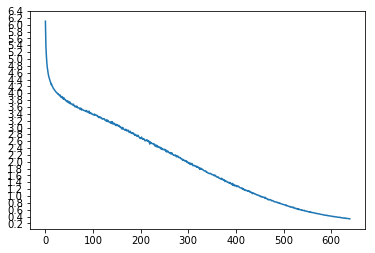

In [318]:
BATCH_SIZE=32
hidden_size=256

train_dataset = VocabDataset(pairs, input_lang.word2index, output_lang.word2index)
# 1 batch input dimension: num_sentences x max sentence length
# 1 batch: source_sentences, target_sentences, source_lengths, target_lengths
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=BATCH_SIZE,
                                           collate_fn=vocab_collate_func,
                                           shuffle=True)

encoder = EncoderRNN(hidden_size = hidden_size, vocab_size = input_lang.n_words )
decoder = DecoderRNN(hidden_size = hidden_size, vocab_size = output_lang.n_words)

plot_losses = trainIters(train_loader, encoder, decoder, n_iters=2000, 
                         print_every=50, plot_every=100, learning_rate=0.01, teacher_forcing_ratio=0.5)

In [327]:
val_dataset = VocabDataset(pairs_v, input_lang_v.word2index, output_lang_v.word2index)
# 1 batch input dimension: num_sentences x max sentence length
# 1 batch: source_sentences, target_sentences, source_lengths, target_lengths
val_loader = torch.utils.data.DataLoader(dataset=val_dataset,
                                           batch_size=BATCH_SIZE,
                                           collate_fn=vocab_collate_func,
                                           shuffle=False)

In [328]:
decoded, actual = evaluate_batch(val_loader, encoder, decoder)

for i in zip(decoded, actual):
    if i == 10:
        break
    print('\n')
    print('Expected:', i[1])
    print('Actual:' ,i[0])



Expected:  I was so shocked
Actual:  And I did


Expected:  I lost all hope
Actual:  What do


Expected:  Thank you
Actual:  Not very


Expected:  Remi knows what love
Actual:  You will know


Expected:  He screamed a lot
Actual:  I ve just that


Expected:  Extraordinary
Actual: 


Expected:  You can be extraordinary
Actual:  We re very afraid


Expected:  Thank you
Actual:  Right


Expected:  Thank you
Actual:  This is


Expected:  It s everywhere
Actual:  So it s right


Expected:  Not exactly
Actual:  That


Expected:  The answer is easy
Actual:  We all you


Expected:  Thank you
Actual:  That


Expected:  Thank you very much
Actual:  I was gasping


Expected:  A real school
Actual:  No one is


Expected:  There she is
Actual:  We will to it


Expected:  Today I am 22
Actual:  Does you see you


Expected:  My family believes in
Actual:  Hi


Expected:  Thank you
Actual:  Thanks


Expected:  Hold it up
Actual:  He s not here


Expected:  Raw data
Actual:  What are they doing


Exp

In [329]:
evaluate_bleu(decoded, actual)

0.6576123776265187